In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import warnings

warnings.simplefilter("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

In [2]:
def pend(y, t, b, c):
    return b * y - c * y * y

In [3]:
b = 4.
c = 0.5
n = 101
y0 = 0.5
t = np.linspace(0, 10, n)

In [4]:
y = odeint(pend, y0, t, args=(b, c)).T[0]

In [5]:
delta = 0.01 * np.random.randn(len(t))
y_n = y + delta

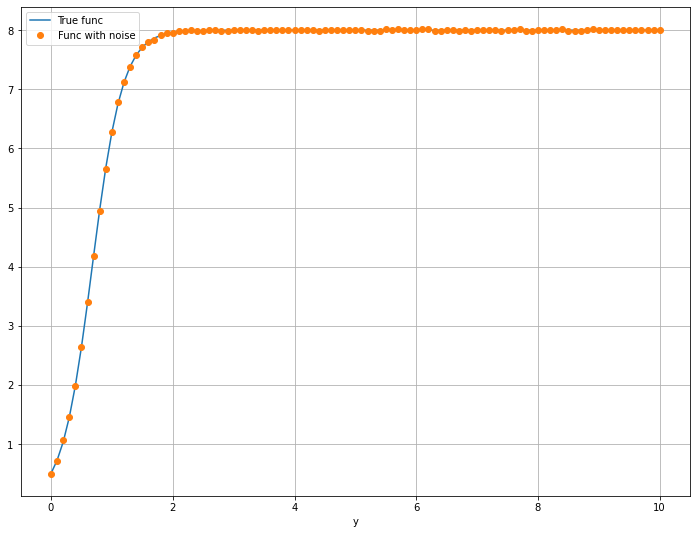

In [6]:
plt.plot(t, y, label='True func')
plt.plot(t, y_n, 'o', label='Func with noise')
plt.xlabel('t')
plt.xlabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

In [7]:
def error_func(w):
    basis = odeint(pend, y0, t, args=(w[0], w[1])).T[0]
    error = 0
    for i in range(n):
        error += (basis[i] - y_n[i]) ** 2
    return error

Начальные параметры
a:   0.570   b:   0.411
Optimization terminated successfully.
         Current function value: 0.009163
         Iterations: 71
         Function evaluations: 135

Параметры аппроксимирующей функции после оптимизации
a:   3.998   b:   0.500

Ошибка после минимизации: 0.009162695638512169

CPU times: user 114 ms, sys: 2.07 ms, total: 116 ms
Wall time: 114 ms


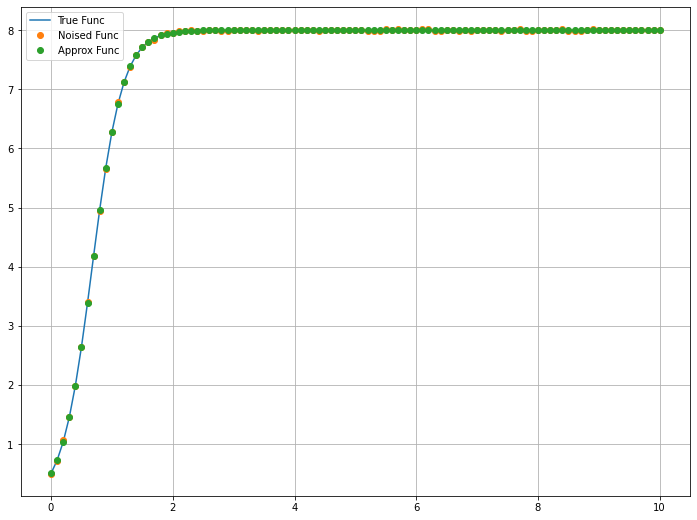

In [8]:
%%time

w = np.random.normal(loc=0, scale=1, size=2)

print('Начальные параметры')
print('a:{:>8.3f}   b:{:>8.3f}'.format(w[0], w[1]))

res = minimize(error_func, w, method='Nelder-Mead', options={'maxiter': 100000,
                                                             'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
print('a:{:>8.3f}   b:{:>8.3f}'.format(res.x[0], res.x[1]))

print()
print('Ошибка после минимизации:', res.fun)
print()

plt.plot(t, y, label='True Func');
plt.plot(t, y_n, 'o', label='Noised Func');
plt.plot(t, odeint(pend, y0, t, args=(res.x[0], res.x[1])).T[0], 'o', label='Approx Func');
plt.legend(loc='best')
plt.grid()

# Хищник - жертва

In [9]:
def derivative(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (-alpha + beta * y)
    doty = y * (delta - gamma * x)
    return np.array([dotx, doty])

In [10]:
def basis_functions_deriv1(X, t, alpha, beta, delta, gamma, f1, f2):
    if(t > 1.0):
        x = f1(1.0)
        y = f2(1.0)
    else:
        x = f1(t)
        y = f2(t)
    zx, zy = X
    dzdotx = zx * (beta * y - alpha) + zy * beta * x - x
    dzdoty = zy * (delta - gamma * x) - zx * gamma * y
    return np.array([dzdotx, dzdoty])

def basis_functions_deriv2(X, t, alpha, beta, delta, gamma, f1, f2):
    if(t > 1.0):
        x = f1(1.0)
        y = f2(1.0)
    else:
        x = f1(t)
        y = f2(t)
    zx, zy = X
    dzdotx = zx * (beta * y - alpha) + zy * beta * x + x * y
    dzdoty = zy * (delta - gamma * x) - zx * gamma * y
    return np.array([dzdotx, dzdoty])

def basis_functions_deriv3(X, t, alpha, beta, delta, gamma, f1, f2):
    if(t > 1.0):
        x = f1(1.0)
        y = f2(1.0)
    else:
        x = f1(t)
        y = f2(t)
    zx, zy = X
    dzdotx = zx * (beta * y - alpha) + zy * beta * x
    dzdoty = zy * (delta - gamma * x) - zx * gamma * y + y
    return np.array([dzdotx, dzdoty])

def basis_functions_deriv4(X, t, alpha, beta, delta, gamma, f1, f2):
    if(t > 1.0):
        x = f1(1.0)
        y = f2(1.0)
    else:
        x = f1(t)
        y = f2(t)
    zx, zy = X
    dzdotx = zx * (beta * y - alpha) + zy * beta * x
    dzdoty = zy * (delta - gamma * x) - zx * gamma * y - x * y
    return np.array([dzdotx, dzdoty])

In [11]:
def error_func(w):
    basis = odeint(derivative, X0, t, args = (w[0], w[1], w[2], w[3]))
    x, y = basis.T
    error = 0
    for i in range(N):
        error += (y[i] - y_n[i]) ** 2 + (x[i] - x_n[i]) ** 2
    return error

In [12]:
def error_func_deriv(w):
    basis = odeint(derivative, X0, t, args = (w[0], w[1], w[2], w[3]))
    x, y = basis.T
    
    f1 = interp1d(t, x_n)
    f2 = interp1d(t, y_n)
    
    basis_deriv1 = odeint(basis_functions_deriv1, X0, t, args=(w[0], w[1], w[2], w[3], f1, f2))
    basis_deriv1x, basis_deriv1y = basis_deriv1.T
    basis_deriv2 = odeint(basis_functions_deriv2, X0, t, args=(w[0], w[1], w[2], w[3], f1, f2))
    basis_deriv2x, basis_deriv2y = basis_deriv2.T
    basis_deriv3 = odeint(basis_functions_deriv3, X0, t, args=(w[0], w[1], w[2], w[3], f1, f2))
    basis_deriv3x, basis_deriv3y = basis_deriv3.T
    basis_deriv4 = odeint(basis_functions_deriv4, X0, t, args=(w[0], w[1], w[2], w[3], f1, f2))
    basis_deriv4x, basis_deriv4y = basis_deriv4.T
    
    error_deriv = np.zeros(4)
    error_deriv[0] = 2 * np.sum((x - x_n) * basis_deriv1x, axis=0) + 2 * np.sum((y - y_n) * basis_deriv1y, axis=0)
    error_deriv[1] = 2 * np.sum((x - x_n) * basis_deriv2x, axis=0) + 2 * np.sum((y - y_n) * basis_deriv2y, axis=0)
    error_deriv[2] = 2 * np.sum((x - x_n) * basis_deriv3x, axis=0) + 2 * np.sum((y - y_n) * basis_deriv3y, axis=0)
    error_deriv[3] = 2 * np.sum((x - x_n) * basis_deriv4x, axis=0) + 2 * np.sum((y - y_n) * basis_deriv4y, axis=0)
    
    return error_deriv

In [13]:
alpha = 1.
beta = 1.
delta = 1.
gamma = 1.

In [14]:
N = 200

t = np.linspace(0., 8.4, N)

X0 = [4., 2.]

res = odeint(derivative, X0, t, args = (alpha, beta, delta, gamma))

x, y = res.T

In [15]:
x_n = []
y_n = []
x_n = x + 0.05 * np.random.randn(len(x))
y_n = y + 0.05 * np.random.randn(len(y))

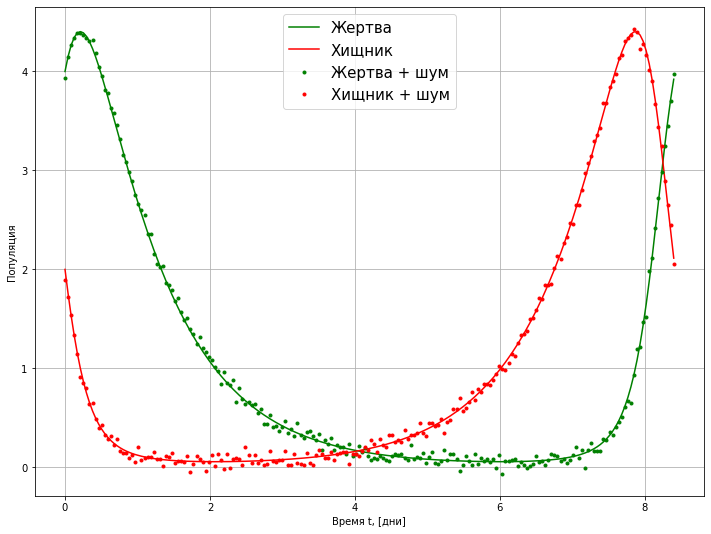

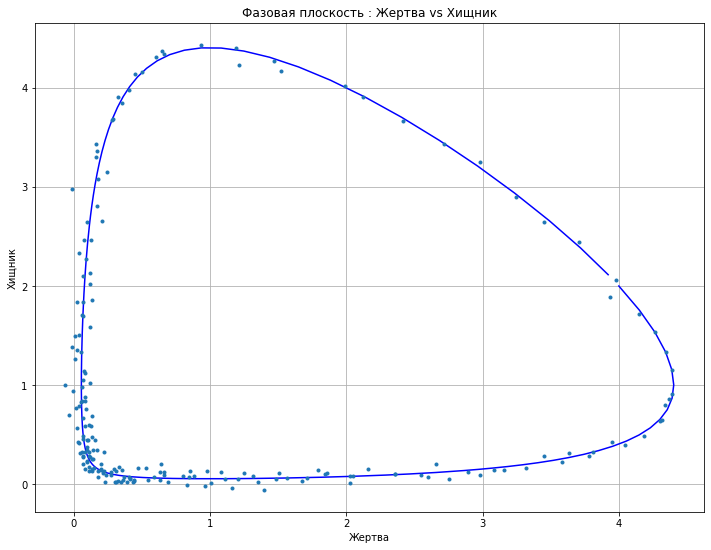

In [16]:
plt.figure()
plt.grid()
plt.plot(t, x, 'g', label = 'Жертва')
plt.plot(t, y, 'r', label = "Хищник")
plt.plot(t, x_n, '.g', label = 'Жертва + шум')
plt.plot(t, y_n, '.r', label = "Хищник + шум")
plt.xlabel('Время t, [дни]')
plt.ylabel('Популяция')
plt.legend(prop={'size': 15})
plt.show()

plt.figure()
plt.plot(x, y, "-b")
plt.plot(x_n, y_n, ".")
plt.xlabel("Жертва")
plt.ylabel("Хищник")
plt.grid()
plt.title("Фазовая плоскость : Жертва vs Хищник");

In [17]:
w = [1.5, 2.5, 0., 1]

print('Начальные параметры')
print('a:{:>8.3f}   b:{:>8.3f}   c:{:>8.3f}   d:{:>8.3f}'.format(w[0], w[1], w[2], w[3]))

res = minimize(error_func, w, method='Nelder-Mead', options={'maxiter': 100000,
                                                             'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
print('a:{:>8.3f}   b:{:>8.3f}   c:{:>8.3f}   d:{:>8.3f}'.format(res.x[0], res.x[1], res.x[2], res.x[3]))

print()
print('Ошибка после минимизации:', res.fun)
print()

Начальные параметры
a:   1.500   b:   2.500   c:   0.000   d:   1.000
Optimization terminated successfully.
         Current function value: 0.959493
         Iterations: 573
         Function evaluations: 948

Параметры аппроксимирующей функции после оптимизации
a:   0.996   b:   0.996   c:   1.001   d:   0.995

Ошибка после минимизации: 0.9594928789117787



In [18]:
x_r, y_r = odeint(derivative, X0, t, args = (res.x[0], res.x[1], res.x[2], res.x[3])).T

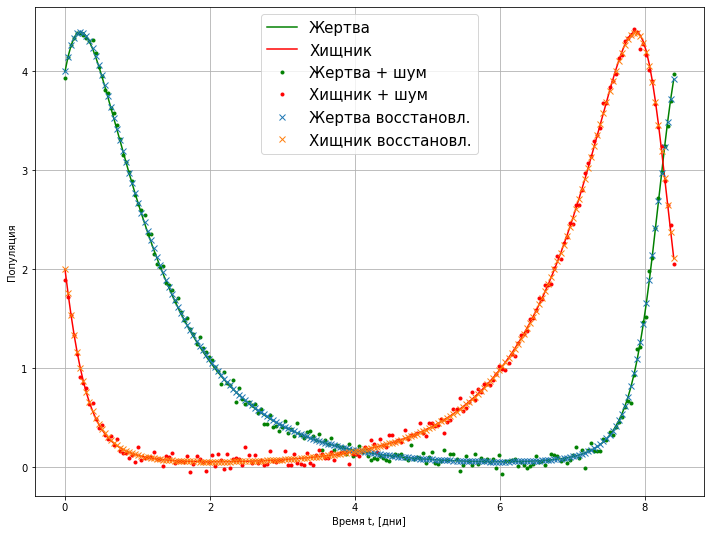

In [19]:
plt.figure()
plt.grid()
plt.plot(t, x, 'g', label = 'Жертва')
plt.plot(t, y, 'r', label = "Хищник")
plt.plot(t, x_n, '.g', label = 'Жертва + шум')
plt.plot(t, y_n, '.r', label = "Хищник + шум")
plt.plot(t, x_r, 'x', label = 'Жертва восстановл.')
plt.plot(t, y_r, 'x', label = "Хищник восстановл.")
plt.xlabel('Время t, [дни]')
plt.ylabel('Популяция')
plt.legend(prop={'size': 15})
plt.show()

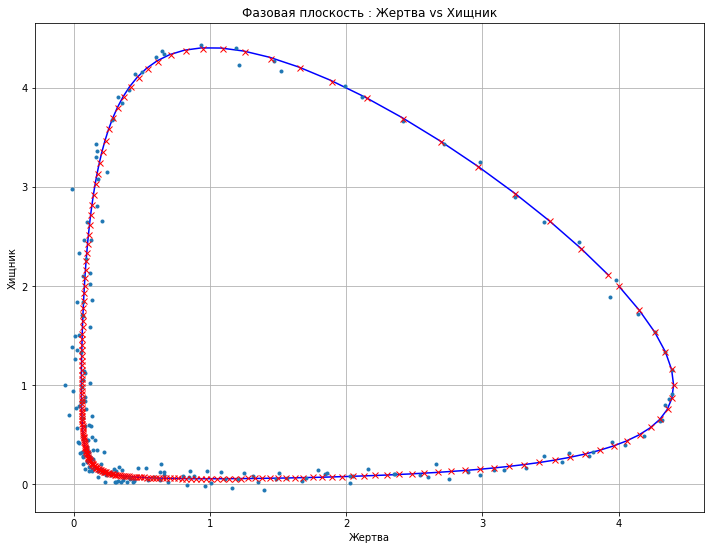

In [20]:
plt.figure()
plt.plot(x, y, "-b")
plt.plot(x_n, y_n, ".")
plt.plot(x_r, y_r, "xr")
plt.xlabel("Жертва")
plt.ylabel("Хищник")
plt.grid()
plt.title("Фазовая плоскость : Жертва vs Хищник");

In [21]:
print('Начальные параметры')
print('a:{:>8.3f}   b:{:>8.3f}   c:{:>8.3f}   d:{:>8.3f}'.format(w[0], w[1], w[2], w[3]))

res = minimize(error_func, w, method='BFGS', jac=error_func_deriv, options={'maxiter':10000,
                                                                            'disp': True})
                                                   
print('\nПараметры аппроксимирующей функции после оптимизации')
print('a:{:>8.3f}   b:{:>8.3f}   c:{:>8.3f}   d:{:>8.3f}'.format(res.x[0], res.x[1], res.x[2], res.x[3]))

print()
print('Ошибка после минимизации:', res.fun)
print()

Начальные параметры
a:   1.500   b:   2.500   c:   0.000   d:   1.000
Optimization terminated successfully.
         Current function value: 0.959493
         Iterations: 20
         Function evaluations: 1082

Параметры аппроксимирующей функции после оптимизации
a:   0.996   b:   0.996   c:   1.001   d:   0.995

Ошибка после минимизации: 0.959492622658609



In [22]:
x_r, y_r = odeint(derivative, X0, t, args = (res.x[0], res.x[1], res.x[2], res.x[3])).T

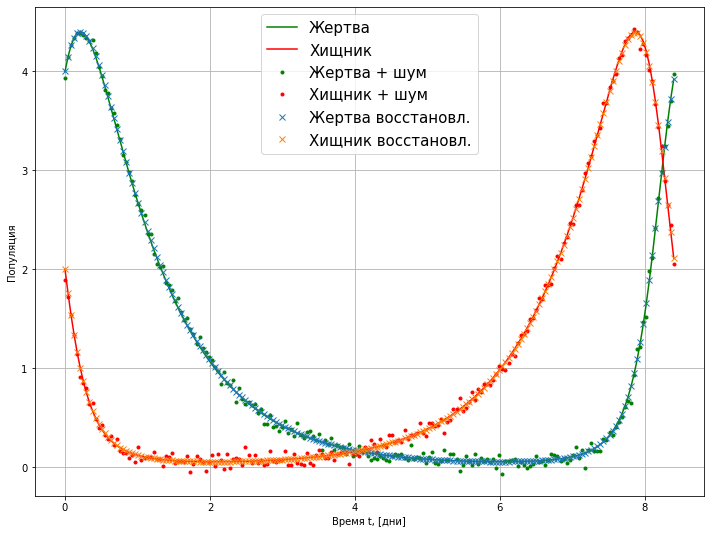

In [23]:
plt.figure()
plt.grid()
plt.plot(t, x, 'g', label = 'Жертва')
plt.plot(t, y, 'r', label = "Хищник")
plt.plot(t, x_n, '.g', label = 'Жертва + шум')
plt.plot(t, y_n, '.r', label = "Хищник + шум")
plt.plot(t, x_r, 'x', label = 'Жертва восстановл.')
plt.plot(t, y_r, 'x', label = "Хищник восстановл.")
plt.xlabel('Время t, [дни]')
plt.ylabel('Популяция')
plt.legend(prop={'size': 15})
plt.show()

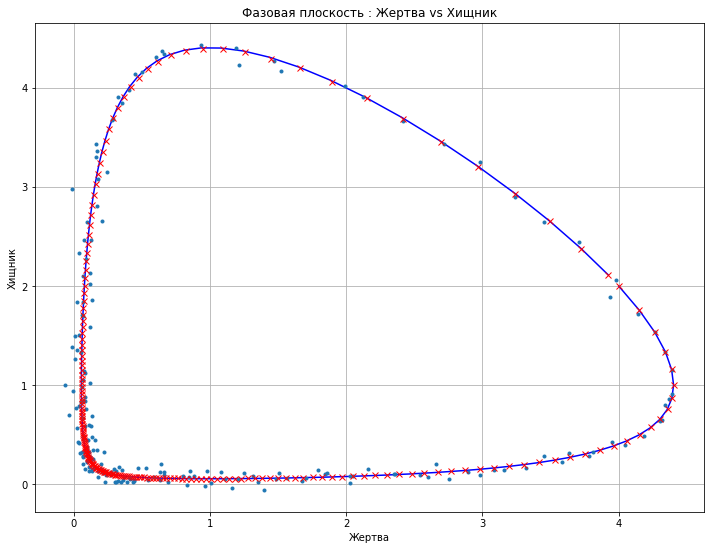

In [24]:
plt.figure()
plt.plot(x, y, "-b")
plt.plot(x_n, y_n, ".")
plt.plot(x_r, y_r, "xr")
plt.xlabel("Жертва")
plt.ylabel("Хищник")
plt.grid()
plt.title("Фазовая плоскость : Жертва vs Хищник");